# Application:  Crystallization Kinetics of Amorphous $TiO_2$

For the next 3 weeks of lessons, we will look at several different methods of fitting data. All lessons will pull data from the literature using the digitizing functions (`selectdata()`, `cal()`) we created in the last couple of lessons.  

:::{admonition} Learning Objectives  
**Application 1:** `Scipy curve_fit()` (this week)  
a. Application: Crystallization Kinetics of Amorphous  𝑇𝑖𝑂2 . (Thin Solid Films 519 (2010) 1649-1654)  
b. Single Peak Fitting of XRD data  
c. Integration under a curve  
d. Fitting Transformation vs Time data to the Avrami Equation (You saw the Avrami equation in Chapter 10 of Callister)  
e. We will fit data that the author's of the publication could not without creating an additional fitting parameter which invalidated their entire analysis.  
:::

:::{image} ../images/09_reference.png
:height: 400px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_reference.png" width=600px>

The Xray diffraction data below is for a 180 nm sample of $TiO_2$ that is initially amorphous at room temperature. The temperature of the amorphous sample was increased as indicated to begin the crystallization process (the amorphous phase is unstable).  The presence of a peak in the Xray data indicates the presence of the crystalline phase.  The "size" of the peak (area under the curve) is proportional to the fraction of the sample that has been crystallized.  Notice that the peak no longer changes after 260 C.  This is because at this point the sample is 100% crystallized.  We can take the area under the 280 C curve to represent 100% crystalline $TiO_2$. 

:::{image} ../images/09_xrd.png
:height: 500px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_xrd.png" width=600px>

Another way to collect the data is to calculate the area under the peak at a fixed temperature as a function of time.  In this way we can get the fraction of the sample that has been crystallized as a function of time.  

:::{image} ../images/09_crystalliz_data.png
:height: 500px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_crystalliz_data.png" width=600px>

Fitting the curves in the above figure to the avrami equation, allows us to calculate the avrami constants, $k$ and $n$.  The variable labeled $t_0$ here is not correct.  This is the parameter that the authors added to the avrami equation to help them fit the data.  This was not necessary and had the unfortunate result of making their $k$ and $n$ values incorrect.  We will fix this.  

:::{image} ../images/09_avrami_numbers.png
:height: 500px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_avrami_numbers.png" width=600px>

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import sympy as sym
import os

# pixel data stored in variable "pixel_positions"
def selectdata(path_to_image_file, filename):
    ''' 
        path_to_image_file example: r"C:/Users/Sean/images" 
        filename example: "xrd data.png"  
        pixel data stored in global variable "pixel_positions"
    '''
    plt.close('all')
    %matplotlib widget

    image_file=os.path.join(path_to_image_file, filename)
    
    #now we have 1 row and 2 columns i.e. 2 figures in a row
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12, 4),gridspec_kw={'width_ratios': [1,1]})

    # gridspec_kw={'width_ratios': [2, 2]} can be used above if needed

    # turn off the x, y axis on the image - the axis doesn't make sense for an image
    ax1.axis(False)
    
    img = mpimg.imread(image_file) #matplotlib
    # .add_axes([left, bottom, width, height])
    image_axis = fig.add_axes([0.015, 0, 0.40, 0.9], zorder=10, anchor=(0.5,0.5)) #zorder places figure on top of anything else in axes
    image_axis.imshow(img)
    image_axis.axis('off')

    # recall from part 1 that image files have coord in left top corner so we need to correct by the y-dimension of the file
    ydim=img.shape[0]

    # setting title and labels for ax1 (figure on the left)
    ax1.set_title('Click on the plot below to collect pixel positions.', pad=10, loc='left')
    ax1.set_xlabel('x-pixel position')
    ax1.set_ylabel('y-pixel position')

    global pixel_positions #makes pixel_positions a global variable so we have access to it outside this function
    pixel_positions = []
    def onclick(event):
        if event.button==1:
            pixel_positions.append([event.xdata,ydim-event.ydata])
            ax2.set_title(f'Last click: [{event.xdata:.3f}, {ydim-event.ydata:.3f}]')
            ax2.scatter(event.xdata, ydim-event.ydata, marker='o', c='r', edgecolor='k') #adding scatter plot
        elif event.button==3:
            tt=[[round(number[0],3),round(number[1],3)] for number in pixel_positions]
            fig.text(0.2,0.5,f'pixel positions = {tt}', fontsize=8, zorder=20,ha='left',wrap=True, backgroundcolor='white')
            fig.canvas.mpl_disconnect(cid)
        else: pass
    
    cid=fig.canvas.mpl_connect('button_press_event', onclick) 
    plt.show()
    
def cal(pixpts, plotpts, datatoconvert):    
    ''' 
        Needs numpy as np
        pixpts = list of three pixel points (typically along axes)
        plotpts = list of three points corresponding to pixpts but in plot units
        datatoconvert = list of pixel points to convert to plot coordinates
    '''
    
    xpx1, ypx1 = pixpts[0]
    x1, y1 = plotpts[0]
    xpx2, ypx2 = pixpts[1]
    x2, y2 = plotpts[1]
    xpx3, ypx3 = pixpts[2]
    x3, y3 = plotpts[2]
    
    # general solution for calibration constants
    m11=(x1*ypx2 - x1*ypx3 - x2*ypx1 + x2*ypx3 + x3*ypx1 - x3*ypx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m12=-(x1*xpx2 - x1*xpx3 - x2*xpx1 + x2*xpx3 + x3*xpx1 - x3*xpx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m21=(y1*ypx2 - y1*ypx3 - y2*ypx1 + y2*ypx3 + y3*ypx1 - y3*ypx2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    m22=-(-xpx1*y2 + xpx1*y3 + xpx2*y1 - xpx2*y3 - xpx3*y1 + xpx3*y2)/(xpx1*ypx2 - xpx1*ypx3 - xpx2*ypx1 + xpx2*ypx3 + xpx3*ypx1 - xpx3*ypx2)
    Ox=(-x1*xpx2*y3 + x1*xpx3*y2 + x2*xpx1*y3 - x2*xpx3*y1 - x3*xpx1*y2 + x3*xpx2*y1)/(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)
    Oy=(x1*y2*ypx3 - x1*y3*ypx2 - x2*y1*ypx3 + x2*y3*ypx1 + x3*y1*ypx2 - x3*y2*ypx1)/(x1*y2 - x1*y3 - x2*y1 + x2*y3 + x3*y1 - x3*y2)
    
    # define our calibrated transf matrix, m_cal, and our calibrated offset, offset_cal
    m_cal=[[m11, m12],[m21,m22]]
    offset_cal=[Ox, Oy]
    
    # return as numpy arrays
    # return(np.array(m_cal), np.array(offset_cal))
    plot_data=np.array([np.matmul(m_cal, point-offset_cal) for point in np.array(datatoconvert)])

    return(plot_data)


## 1. First run the cell below and click on THREE calibration points of your choosing. 
##### You can zoom your window or magnify your view to get a more accurate selection of points. 

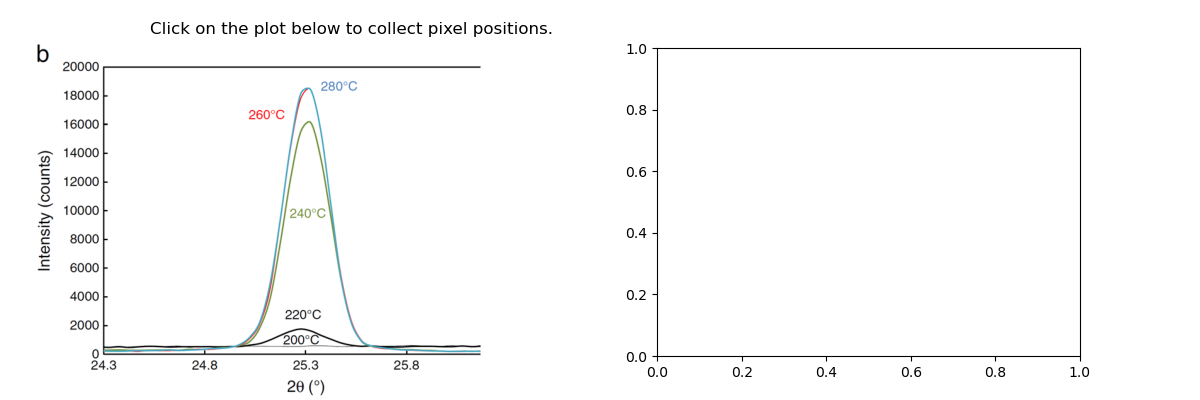

In [178]:
path="..\images"
filename='09_xrd.png'
fullpath=os.path.join(path, filename)

tt=selectdata(path, filename)

Your output from above should look something like this: 

:::{image} ../images/09_pix_cal.png
:height: 500px
:name: navigator
:align: center
:::

<img alt="" src="../images/09_pix_cal.png" width=800px>

I chose points: 
```Python
[[25.8,0],[24.3,0],[24.3,20000]]
```

### After clicking on your three points above, run the cell below.  This will copy the three points currently saved as "pixel_positions" into variable "pix_pts".  
#### But first, fill in the corresponding plot values for the points you chose in "plot_pts" variable below. 

In [ ]:
# calib pts from plot
pix_pts=pixel_positions 
# check to see if you need to change the points below
# and check that they are in the correct order
plot_pts=[[25.8,0],[24.3,0],[24.3,20000]] #these should correspond to the three pts you picked and in the same order as pix_pts

## Now repeat and select points from the 280 degree curve

In [ ]:
selectdata(fullpath)

My data looked like: 
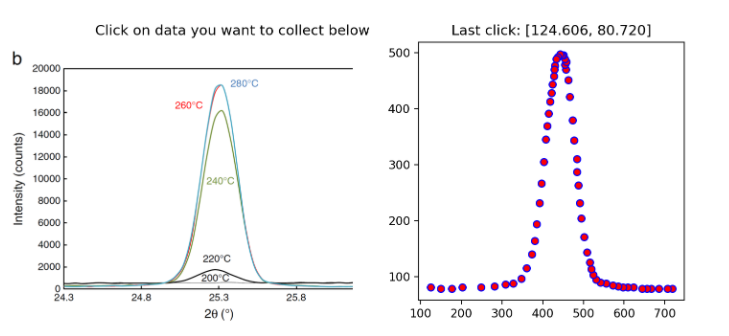

here we save the points to variable "pix_data280"

In [ ]:
pix_data280=pixel_positions

## repeat again for the 240  degree data
#### are you getting the hang of it yet?

In [ ]:
selectdata(fullpath)

... and copy to variable pix_data240

In [ ]:
pix_data240=pixel_positions

if all is well, the following should calibrate and turn your pixel data into plot coordinates.  The plot coordinate data will be copied to plot_data1 and plot_data2

In [ ]:
%matplotlib inline
plot_data1=cal(pix_pts, plot_pts, pix_data280)
plot_data2=cal(pix_pts, plot_pts, pix_data240)
    
plt.subplots(figsize=[5,4])
plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.')
plt.plot(plot_data2[:,0], plot_data2[:,1], 'b.')
plt.show()

## Now let's work on fitting our peak data so we can integrate to find the area under the peak later. 
#### There are several peak functions that can be used and I've given 3 more examples in the Appendix.  Below shows the Lorentzian distribution where $A$ is the amplitude, $\mu$ is the position of the peak, and $\sigma$ defines the peak width.  For our data, $x$ would be the angle, $2 \theta$. 

Lorentzian
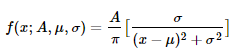

In [ ]:
from scipy.optimize import curve_fit  ## we need our curve fitting routine from scipy

# let's define a function that calculates the lorentzian
def lorentzian(x, amplitude, mean, stddev):
    return amplitude * (stddev/((x-mean)**2+stddev**2))

# let's curve fit our plot_data1. curve_fit returns two values we only need the first which we call
# popt. The second we call "__" as a throw away variable.  
# format here curve_fit(model_name, xdata, ydata, bounds_on_parameters)
popt, _ = curve_fit(lorentzian, plot_data1[:,0], plot_data1[:,1], bounds=[[0, 24, 0],[20000,26,2]])
# the bounds in the fit above help the routine find a fit.  These are given as [[lower],[upper]]
# where lower correspond to the lower bound for our three variables "amplitude", "mean", & "stddev"
# the order is taken from the order given in the function lorentzian above
# for example the amplitude, mean, and stddev have lower bounds of 0, 24, and 0 respectively 
# and a corresponding upper bound of 20000, 26, and 2 respectively.    

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(np.arange(24.25, 26.5, 0.01), lorentzian(np.arange(24.25, 26.5, 0.01), *popt));

My fit looked like:  
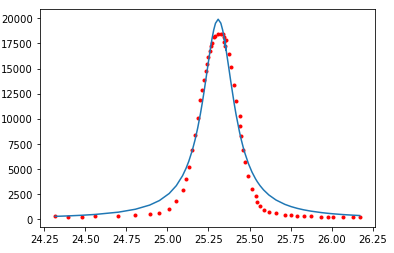
The lorentzian does not do a good job at fitting this data.  We should probably use a different function as defined in the Appendix.   

#### Now we can work on integrating our fitted function over the peak position to find the area under the curve.  The area in this case is proportional to the fraction of crystallization.  To get the fraction crystallized, we would need to compare this area to the area under the 280 C curve.  

In [ ]:
model=lorentzian
import scipy.integrate as integrate
import scipy.special as special

# we use integrate.quad()
result = integrate.quad(lambda x: model(x, *popt), 24.5, 26.1)
result

Now let's curve fit our 240 degree data "plot_data2" and plot the fits and data for the 240 and 280 on one plot

In [ ]:
model=lorentzian

popt2, _ = curve_fit(model, plot_data2[:,0], plot_data2[:,1], bounds=[[0, 24, 0],[20000,26,2]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(np.arange(24.25, 26.5, 0.01), lorentzian(np.arange(24.25, 26.5, 0.01), *popt));
plt.plot(plot_data2[:,0], plot_data2[:,1], 'b.');
plt.plot(np.arange(24.25, 26.5, 0.01), lorentzian(np.arange(24.25, 26.5, 0.01), *popt2));

My output using a weighted lorentzian + gaussian model does a nice job:  
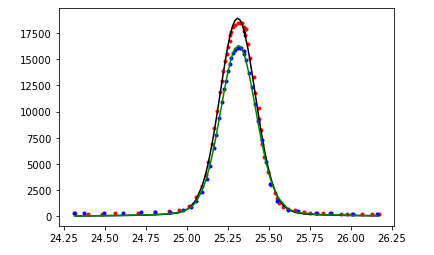

The appendix at the end of this notebook gives the model definition I used.

Integrate the 240 data

In [ ]:
result2 = integrate.quad(lambda x: model(x, *popt2), 24.5, 26.1)
result2

In [ ]:
print(f'If we take the curve at 280 C to represent fully recrystallized with an area of {result[0]:.0f}')
print(f'then we can divide all integrated areas by {result[0]:.0f}')
print(f'the normalized intensity at 240 C = {result2[0]:.0f} / {result[0]:.0f}= {result2[0]/result[0]:.2f}')

## Following the steps in the example above for the Lorentzian distrubution, fit your plot_data1 and plot_data2 to a Gaussian distribution.  The equation is: 
## $$f(x, A, \mu, \sigma)= A \ {\rm e}^{-(x-\mu)^2/(2\ \sigma^2)}$$

## Now let's look at the Normalized Intensity vs time data
### The author's of the publication could not fit this data without creating an additional fitting parameter which invalidated their entire analysis.  You will see that this was completely unnecessary.  
#### Each point on each of these curves corresponds to the relative area under the peak data as we just performed previously.  

In [ ]:
path=r"C:\Users\Sean\OneDrive - Virginia Tech\Documents\Teaching\2114 & 3114 Math I & II\git_2114_3114\images"
filename='crystalliz data intensity time.png'
fullpath=os.path.join(path, filename)

selectdata(fullpath)

Remember to recalibrate since we have a new image.  My three points: 
```Python
[[150,0],[0,0],[0,1]]
```

In [ ]:
# change these calibration points to your values
pixpts=[[694,86],[99,86],[100,463]]
pltpts=[[150,0],[0,0],[0,1]]

grab points for the 180 nm data

In [ ]:
selectdata(fullpath)

My data looked like: 
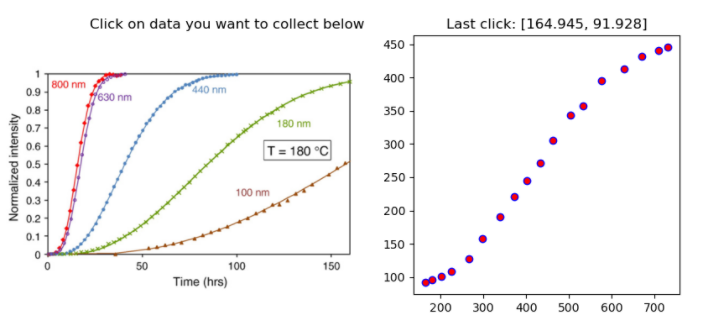

In [ ]:
dataset180=pixel_positions

grab points for the 630 nm data

In [ ]:
selectdata(fullpath)

In [ ]:
dataset630=pixel_positions

Calibrate and convert your data and plot

In [ ]:
plot_data1=cal(pixpts, pltpts, dataset180)
plot_data2=cal(pixpts, pltpts, dataset630)
    
plt.subplots(figsize=[5,4])
plt.plot(plot_data1[:,0], plot_data1[:,1], 'ro')
plt.plot(plot_data2[:,0], plot_data2[:,1], 'bo')
plt.show()

My output looked like: 
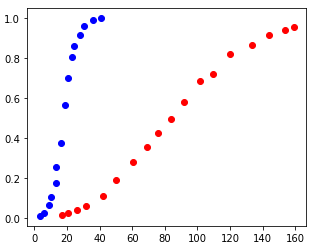

## Not done yet.  Now we just need to fit our data with the avrami equation to determine the crystallization kinetic parameters, k & n

Avrami equation (recall this from Callister, Chap 10)
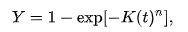

In [ ]:
from scipy.optimize import curve_fit
%matplotlib inline

def avrami(t,k,n):
    return(1-np.exp(-k*t**n))

# nonlinear fits can be a bit sensitive so you may have to play with the initial guess "p0" to get a good fit
# here I used an initial guess, p0, for the parameters, k & n, rather than using bounds
popt, _ = curve_fit(avrami, plot_data1[:,0], plot_data1[:,1], p0=[1e-3, 2])

print(popt)
plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.', label='data');
plt.plot(plot_data1[:,0], avrami(plot_data1[:,0], *popt), label="fit");
plt.xlabel('t, hrs')
plt.ylabel('crystallization fraction')
plt.legend();
plt.show()


My output and fit: 
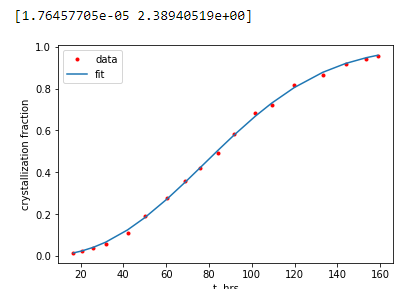

### Repeat this for your 630 nm data and plot everything (180 & 630 & fits) on one plot

## Compare your values for n for the 180 and 630 data to that of the paper.  
#### Paper fitting values for n.   180nm:  n = 2.25 and 630nm: n=2.5

Why are your answers different than the values from the paper?  Because the authors performed a fit using a bad function.  They chose to fit $y=1-exp(-k  (t-t_0)^n)$  rather than the simple avrami equation $y=1-exp(-k  t^n)$.  

They added the $t_0$ parameter because they could not fit the data without it.  They claimed that $t_0$ represented an incubation time for nucleation but this is nonsense since this is already built into the Avrami equation!  See notes on the avrami equation in your Callister text. 

# Appendix (just for your information)

### Three additional peak functions that are sometimes used

##### Gaussian
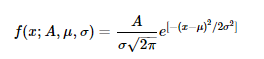

In [ ]:
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-1/2*((x - mean) / stddev)**2)

popt, _ = curve_fit(gaussian, plot_data1[:,0], plot_data1[:,1], p0=[10000, 25, 0.5], bounds=[[5000, 24, 0],[20000,26,2]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(plot_data1[:,0], gaussian(plot_data1[:,0], *popt));

Gaussian model:
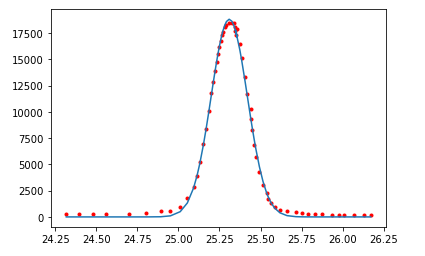

##### Voigt
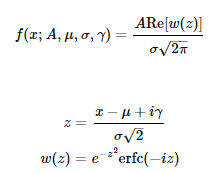

In [ ]:
from scipy.special import erfc

# def voigt(x, amplitude, mean, stddev, gamma):
#     z=(x-mean+gamma*1j)/(stddev*np.sqrt(2))
#     w=np.exp(-1*z**2)*erfc(-z*1j)
#     return amplitude * np.real(w)/(stddev*np.sqrt(2*np.pi))

def voigt(x, amplitude, mean, stddev,c):
    gamma=c*stddev #gamma is often constrained to equal stddev this line lets us fit gamma but define it relative to stddev
    z=(x-mean+gamma*1j)/(stddev*np.sqrt(2))
    w=np.exp(-1*z**2)*erfc(-z*1j)
    return amplitude * np.real(w)/(stddev*np.sqrt(2*np.pi))

popt, _ = curve_fit(voigt, plot_data1[:,0], plot_data1[:,1], bounds=[[300, 24, 0,0.01],[20000,26,2,1]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(plot_data1[:,0], voigt(plot_data1[:,0], *popt));

Voigt model:
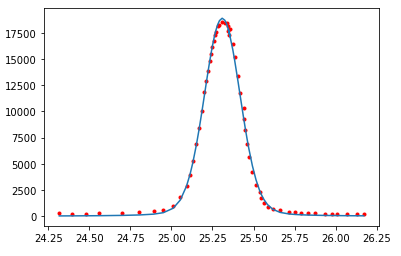

##### Weighted sum of Gaussian and Lorentz
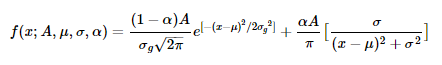


In [ ]:
def gaussian(x, amplitude, mean, stddev, alpha):
    stddevg=stddev/(2*np.log(2))
    return (1-alpha)*amplitude * np.exp(-1/2*((x - mean) / stddevg)**2)

def lorentzian(x, amplitude, mean, stddev, alpha):
    return alpha*amplitude * (stddev/((x-mean)**2+stddev**2))

def model(x,amplitude, mean, stddev, alpha):
    return(gaussian(x,amplitude, mean, stddev, alpha)+lorentzian(x,amplitude, mean, stddev, alpha))

popt, _ = curve_fit(model, plot_data1[:,0], plot_data1[:,1], bounds=[[0, 24, 0,0],[20000,26,2,1]])

plt.plot(plot_data1[:,0], plot_data1[:,1], 'r.');
plt.plot(plot_data1[:,0], model(plot_data1[:,0], *popt));

Gaussian + Lorentzian fit
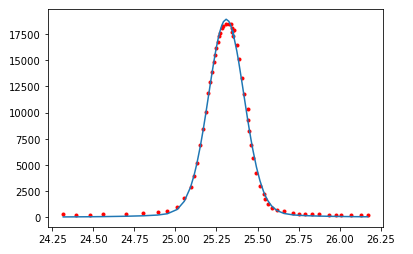